In [24]:
import numpy as np
import networkx as nx
import pandas
import matplotlib.pyplot as plt
import itertools
import scipy
import tqdm
import copy

## Load data

In [25]:
dataset = "small"
datadir = "data/"
df = pandas.read_csv(datadir + dataset+".csv")
df[:5]

,age,portembarked,fare,numparentschildren,passengerclass,sex,numsiblings,survived
0,1,1,1,1,1,1,1,1
1,2,2,1,1,2,2,1,2
2,1,1,1,1,1,2,1,2
3,2,1,1,1,2,2,1,2
4,2,1,1,1,1,1,1,1


In [26]:
column_names = list(df.columns)
data = np.array(df)
node_info = [(column_names[i], (np.min(data[:,i]), np.max(data[:,i]))) for i in range(data.shape[1])]
print(node_info)
print(len(node_info))

[('age', (1, 3)), ('portembarked', (1, 3)), ('fare', (1, 3)), ('numparentschildren', (1, 3)), ('passengerclass', (1, 3)), ('sex', (1, 2)), ('numsiblings', (1, 3)), ('survived', (1, 2))]
8


## BayesNet Datastructure

In [31]:
class BayesNet:
    
    def __init__(self, graph, node_info, adjacency_matrix=None):
        if adjacency_matrix is not None:
            self.adjacency_matrix = adjacency_matrix
            self.G = nx.convert_matrix.from_numpy_array(self.adjacency_matrix, create_using=nx.DiGraph())
        else:
            self.G = graph
        
        if self.is_dag:
            self.node_info = node_info
            self.node_names = [info[0] for info in self.node_info]
            self.n_nodes = len(self.node_info)

            self.vals_per_node = [vals[1] for name, vals in node_info]
            self.node_values = [np.arange(vals[0], vals[1] + 1) for name, vals in node_info]
            self.parent_sets = [list(self.G.predecessors(i)) for i in self.G.nodes]

            n_parental_instances = [np.prod([self.vals_per_node[p] for p in parents]) for parents in self.parent_sets]
            m_matrices = [np.zeros((int(npis), int(vals))) for npis, vals in zip(n_parental_instances, self.vals_per_node)]

            self.ms = m_matrices
    
    def count_ms(self, data):
        for i in range(self.n_nodes):
            parents = self.parent_sets[i]
            n_parents = len(parents)
            if n_parents > 0:
#                 parental_instantiations = itertools.product(*[self.node_values[p] for p in parents])
#                 print("hi")
#                 for j,pi in enumerate(parental_instantiations):
#                     for d in data:
#                         if np.all([d[pp] == pip for pp, pip in zip(parents, pi)]):
#                             self.ms[i][j, d[i] - 1] += 1
#                 import pdb;
#                 pdb.set_trace()
                parental_instantiations = itertools.product(*[self.node_values[p] for p in parents])
                for j, pi in enumerate(parental_instantiations):
                    mask = data[:,parents[0]] == pi[0]
                    for k in range(1,n_parents):
                        mask = np.logical_and(mask, data[:,parents[k]] == pi[k])
                    pi_data = data[mask,i]
                    vals, counts = np.unique(pi_data, return_counts=True)
                    self.update_counts(i, j, vals, counts)
            else:
                vals, counts = np.unique(data[:,i], return_counts=True)
                self.update_counts(i, 0, vals, counts)
    
    def update_counts(self, node, pi, vals, counts):
        for v, c in zip(vals, counts):
            self.ms[node][pi, v - 1] += c
    
    @property
    def is_dag(self):
        return nx.is_directed_acyclic_graph(self.G)
    
    def draw(self):
        nx.draw(self.G, labels={i:info[0] for i, info in enumerate(self.node_info)})
        
    def save(self, filename):
        with open(filename, 'w') as f:
            for edge in self.G.edges():
                f.write("{}, {}\n".format(self.node_names[edge[0]], self.node_names[edge[1]]))
        

In [32]:
def get_dag(p):
    no_dag = True
    while no_dag:    
        A = np.random.binomial(1, p, size=[len(node_info)] * 2)
        np.fill_diagonal(A, 0)
        g = BayesNet(None, node_info, adjacency_matrix=A)
        no_dag = not g.is_dag
    return g

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.57it/s]


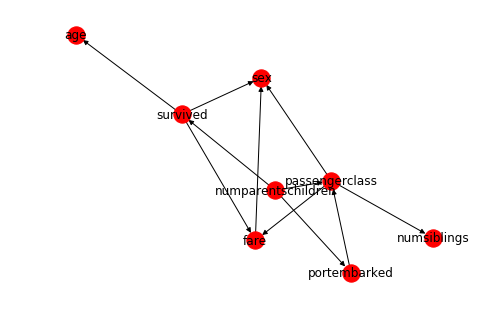

In [33]:
n_dags = 20
p = 0.3
dags = [get_dag(p) for _ in tqdm.tqdm(range(n_dags))]
g = dags[0]
g.draw()

In [34]:
for g in dags:
    g.count_ms(data)

In [35]:
scipy.special.loggamma(1)

0.0

## Compute Bayesian Score

In [36]:
def bay_score_node(m):
    p = np.sum(scipy.special.loggamma(m + 1))
    p += m.shape[0] * scipy.special.loggamma(m.shape[1])
    p -= np.sum(scipy.special.loggamma(m.shape[1] + np.sum(m, axis=1)))
    return p
    
def compute_bayesian_score(g):
    return np.sum([bay_score_node(m) for m in g.ms])

In [37]:
scores = [compute_bayesian_score(g) for g in dags]

In [38]:
gmin = dags[np.argmin(scores)]
gmax = dags[np.argmax(scores)]

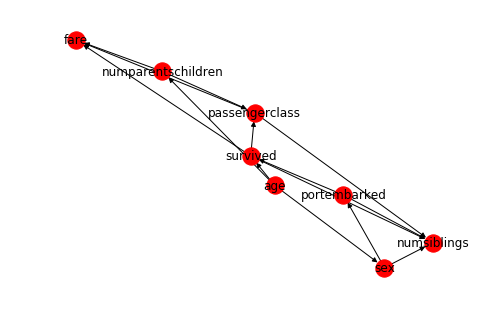

In [39]:
gmin.draw()

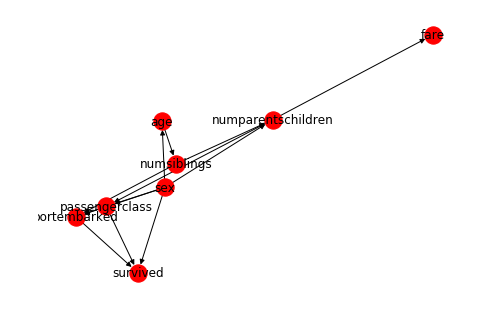

In [40]:
gmax.draw()

## Random Search

In [41]:
hyperparams = {"p_add":.8, "max_parents":6}

def num_parents(g, n):
    parents = list(g.predecessors(n))
    return len(parents)

def generate_neighbor(g):
#     print("hi")
    graph = copy.deepcopy(g.G)
    add_edge = np.random.binomial(1,hyperparams["p_add"])
    modified = False
    if add_edge or len(graph.edges) == 0:
        edges = list(nx.non_edges(graph))
        np.random.shuffle(edges)
        for edge in edges:
#             print(edge)
            if not nx.has_path(graph, edge[1], edge[0]) and num_parents(graph, edge[1]) < hyperparams["max_parents"]:
                graph.add_edge(*edge)
                net = BayesNet(graph, node_info)
                net.count_ms(data)
#                 print(net.is_dag)
                modified = True
                break
    if not add_edge or not modified:
        edges = list(nx.edges(graph))
        l = len(edges)
        edge = edges[np.random.randint(l)]
        graph.remove_edge(*edge)
        net = BayesNet(graph, node_info)
        net.count_ms(data)
#     print(len(net.G.edges))
    return net

In [42]:
def simulated_annealing(initial_candidate, T=1000, epochs=1):
    best_solution = initial_candidate
    best_solution_cost = compute_bayesian_score(initial_candidate)
    
    costs = [best_solution_cost]
    # the best solution we had so far
    
    all_time_best_solution = initial_candidate
    all_time_best_cost = best_solution_cost
    
    while (T > 0):
        print(T)
        for epoch in range(epochs):
            candidate = generate_neighbor(best_solution)
            candidate_cost = compute_bayesian_score(candidate)
            cost_change = candidate_cost - best_solution_cost  # we want to accept higher cost
            if (cost_change > 0):
                # move to candidate state
                best_solution = candidate
                best_solution_cost = candidate_cost
                costs.append(best_solution_cost)
            elif (np.e ** (cost_change / T) > np.random.uniform()):
                # move to candidate state
                best_solution = candidate
                best_solution_cost = candidate_cost
                costs.append(best_solution_cost)
            if all_time_best_cost < candidate_cost:
                all_time_best_solution = candidate
                all_time_best_cost = candidate_cost
        T -= 1
    return all_time_best_solution, all_time_best_cost, costs


## Run simulated annealing

In [43]:
best_solution, best_cost, costs = simulated_annealing(gmax, T=10, epochs=2)

10
9
8
7
6
5
4
3
2
1


-3893.535380453982


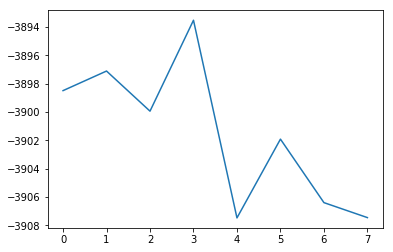

In [44]:
plt.plot(costs)
print(best_cost)

True


-3893.535380453982

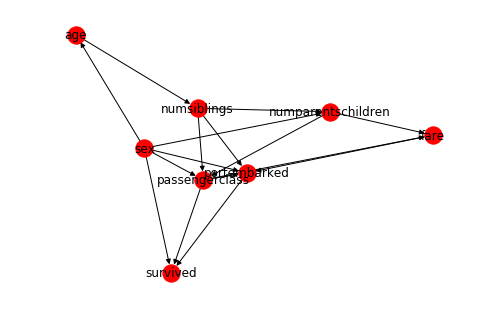

In [45]:
best_solution.draw()
print(best_solution.is_dag)
compute_bayesian_score(best_solution)

## Store results

In [46]:
outdir = "test_outputs3/"
best_solution.save(outdir + dataset + ".gph")

In [64]:
print(best_solution.parent_sets)
print("")
print(best_solution.node_values)

[[3, 4, 7], [0, 7, 4, 2], [], [4, 2], [2], [2, 4, 7, 3, 6], [0, 2, 7, 3], [2, 4, 3]]

[array([1, 2, 3], dtype=int64), array([1, 2, 3], dtype=int64), array([1, 2, 3], dtype=int64), array([1, 2, 3], dtype=int64), array([1, 2, 3], dtype=int64), array([1, 2], dtype=int64), array([1, 2, 3], dtype=int64), array([1, 2], dtype=int64)]


In [37]:
node = 1
best_solution.ms[1].shape
pis = itertools.product(best_solution.node_values[0], best_solution.node_values[6])
m = np.zeros((9,3))
for j,pi in enumerate(pis):
    for d in data:
        if d[0] == pi[0] and d[6] == pi[1]:
            m[j, d[1] - 1] += 1

In [41]:
np.sum(m)

889.0

In [40]:
np.sum(best_solution.ms[1])

889.0

In [ ]:
G = nx.DiGraph()
G.add_edge(1,2)
G.add_edge(3,4)
G.add_edge(4,1)
nx.draw(G, labels={i+1:str(i + 1) for i in range(4)})

In [46]:
A = nx.to_numpy_array(G)

In [68]:
parents = [G.predecessors(node) for node in G.nodes]


[4]

In [42]:
X = np.zeros((3,3))
X[1,0] = 1
X[1,1] = 1
X[1,2] = 1
X[0,0] = 1
X[0,1] = 1

In [44]:
mask = np.logical_and(X[:,0] == 1, X[:,1] == 1)
X[mask,-1]

array([0., 1.])

In [38]:
A[mask]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8 but corresponding boolean dimension is 3

In [49]:
for j in itertools.product((), ()):
    print("hi")

In [51]:
a = np.array([1,1,2,3,4,6,7,3,3])
np.unique(a, return_counts=True)

(array([1, 2, 3, 4, 6, 7]), array([2, 1, 3, 1, 1, 1], dtype=int64))

In [90]:
A = np.zeros((8,8))
# A[0,1] = 1
# A[2,3] = 1
# A[4,5] = 1
g = BayesNet(A, node_info)
g.count_ms(data)
compute_bayesian_score(g.ms)

-4166.225858784904

In [83]:
g.ms

[array([[0., 0., 0.]]), array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), array([[0., 0., 0.]]), array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), array([[0., 0., 0.]]), array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])]

In [84]:
g.parent_sets

[[], [0], [], [2], [], [4]]

In [92]:
nx.convert_matrix.to_numpy_array(g.G)

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [30]:
np.random.shuffle(list(g.G.edges))

OutEdgeView([(0, 1), (0, 2), (0, 7), (1, 3), (3, 5), (3, 6), (4, 2), (4, 7), (5, 2), (6, 5), (7, 6)])

In [49]:
vals = np.random.binomial(1,.1, size = 1000)
np.mean(vals)

0.107

In [82]:
gmax.G.edges

OutEdgeView([(0, 4), (0, 7), (2, 3), (5, 4), (5, 6), (5, 7), (6, 1), (6, 2), (7, 1), (7, 2)])